[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jkitchin/s26-06642/blob/main/dsmles/10-ensemble-methods/ensemble-methods.ipynb)

In [ ]:
! curl -LsSf https://astral.sh/uv/install.sh | sh && \
  uv pip install -q --system "s26-06642 @ git+https://github.com/jkitchin/s26-06642.git"
from pycse.colab import pdf

```{index} ensemble methods
```


# Module 10: Ensemble Methods

Combining multiple models for better predictions.

## Learning Objectives

1. Understand the concept of ensemble learning
2. Apply Random Forests for regression and classification
3. Use Gradient Boosting methods
4. Implement XGBoost for high performance
5. Compare and tune ensemble methods

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

```{index} bagging, boosting
```


## Why Ensemble Methods? The Wisdom of Crowds

The insight behind ensemble methods is simple but powerful: **combining multiple models often beats any single model**.

### Why Does This Work?

Consider weather forecasting. If you ask 10 meteorologists for predictions, averaging their forecasts is often more accurate than any individual forecast. Why?

1. **Different errors cancel out**: Individual models make different mistakes. Averaging reduces the impact of any one model's errors.
2. **Reduced variance**: A single complex model might overfit. Many simple models averaged together are more stable.
3. **Better coverage**: Different models might capture different aspects of the relationship.

### The Two Main Strategies

| Strategy | How It Works | When It Helps |
|----------|--------------|---------------|
| **Bagging** | Train models on random subsets, average | Reduces variance (overfitting) |
| **Boosting** | Train models sequentially, each fixes previous errors | Reduces bias (underfitting) |

### Why Ensembles Dominate in Practice

In machine learning competitions (Kaggle, etc.), ensemble methods win almost every time. In chemical engineering:
- Process data is often noisy → bagging helps
- Relationships are complex → boosting captures nonlinearity
- You care about reliable predictions → ensembles are more stable

In [2]:
# Load catalyst process dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

url = "https://raw.githubusercontent.com/jkitchin/s26-06642/main/dsmles/data/ensemble_process.csv"
df = pd.read_csv(url)

# Extract features and target
feature_cols = ['temperature', 'pressure', 'catalyst_loading', 'residence_time', 'feed_ratio', 'impurity_level']
X = df[feature_cols].values
y = df['conversion'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dataset shape: {df.shape}")
print(f"Features: {feature_cols}")
print(f"Training: {X_train.shape[0]}, Test: {X_test.shape[0]}")
df.head()

Dataset shape: (500, 7)
Features: ['temperature', 'pressure', 'catalyst_loading', 'residence_time', 'feed_ratio', 'impurity_level']
Training: 400, Test: 100


,temperature,pressure,catalyst_loading,residence_time,feed_ratio,impurity_level,conversion
0,374.908024,14.265073,1.007151,31.625825,1.154264,0.082752,0.038907
1,490.142861,11.185831,2.755315,29.271731,1.117447,0.076453,0.061826
2,446.398788,6.881025,4.377435,2.512882,2.765636,0.057353,0.017419
3,419.731697,16.462105,3.687902,21.133622,1.123865,0.095605,0.010324
4,331.203728,14.009892,4.052150,23.431542,1.179874,0.020047,0.048766


In [3]:
# Prepare data
feature_names = ['temperature', 'pressure', 'catalyst_loading', 
                 'residence_time', 'feed_ratio', 'impurity_level']
X = df[feature_names].values
y = df['conversion'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 400
Test samples: 100


```{index} decision tree
```


## Decision Trees: The Building Block

Before understanding ensembles, we need to understand their building block: **decision trees**.

### How Trees Work

A decision tree splits data based on yes/no questions:
- "Is temperature > 400K?" → If yes, go left; if no, go right
- At each leaf, predict the average of training points that land there

### Trees Are Interpretable but Fragile

**Pros**:
- Easy to visualize and explain
- Handle nonlinear relationships naturally
- No scaling required
- Handle mixed feature types

**Cons**:
- High variance: Small changes in data → very different tree
- Prone to overfitting: A deep tree can memorize training data
- Greedy splits: May not find globally optimal structure

### The Overfitting Problem

Watch how a deeper tree fits training data perfectly but generalizes poorly:

In [4]:
# Single decision tree
tree = DecisionTreeRegressor(max_depth=5, random_state=42)
tree.fit(X_train, y_train)

print("Single Decision Tree:")
print(f"  Training R²: {tree.score(X_train, y_train):.4f}")
print(f"  Test R²: {tree.score(X_test, y_test):.4f}")

Single Decision Tree:
  Training R²: 0.6097
  Test R²: -0.2901


In [5]:
# Problem: trees can easily overfit
tree_deep = DecisionTreeRegressor(max_depth=20, random_state=42)
tree_deep.fit(X_train, y_train)

print("Deep Decision Tree (max_depth=20):")
print(f"  Training R²: {tree_deep.score(X_train, y_train):.4f}")
print(f"  Test R²: {tree_deep.score(X_test, y_test):.4f}")
print(f"  Gap: {tree_deep.score(X_train, y_train) - tree_deep.score(X_test, y_test):.4f}")

Deep Decision Tree (max_depth=20):
  Training R²: 1.0000
  Test R²: -0.6341
  Gap: 1.6341


**This is overfitting in action.** The deep tree achieves near-perfect training performance (R² ≈ 0.99) but much worse test performance (R² ≈ 0.85). The "gap" of ~0.14 tells us the model has memorized training data rather than learning generalizable patterns.

What happened? With max_depth=20, the tree created highly specific rules like "if temperature is between 342.7 and 343.1 AND pressure is between 7.23 and 7.31 AND...". These rules fit training noise perfectly but don't apply to new data.

This is exactly why we need ensembles: they combine many imperfect trees into a robust predictor.

```{index} Random Forest, n_estimators, max_depth
```


## Random Forests: Bagging + Random Features

Random Forest is one of the most successful and widely-used algorithms. It fixes trees' problems through two key ideas:

### 1. Bootstrap Aggregating (Bagging)
- Create many random samples (with replacement) from training data
- Train a separate tree on each sample
- Average all trees' predictions

This reduces variance because different trees see different data and make different errors.

### 2. Random Feature Selection
- At each split, only consider a random subset of features
- This decorrelates the trees—they don't all rely on the same strong features

### Why Random Forests Work

| Problem with Single Tree | How Random Forest Fixes It |
|-------------------------|---------------------------|
| High variance | Averaging many trees |
| Overfitting | Bootstrap samples + feature subsets |
| Unstable | Many trees → stable predictions |

### The Magic of Averaging

Even if individual trees are mediocre, their average is often excellent. It's like how the average of many guesses at a jar of jellybeans is often close to the true count.

In [6]:
# Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

print("Random Forest (100 trees):")
print(f"  Training R²: {rf.score(X_train, y_train):.4f}")
print(f"  Test R²: {rf.score(X_test, y_test):.4f}")

Random Forest (100 trees):
  Training R²: 0.8991
  Test R²: 0.1746


**Key observations:**

1. **Diminishing returns**: Performance improves rapidly from 1-50 trees, then levels off. The curve shows that ~100 trees captures most of the benefit; 200 trees gives marginal improvement.

2. **No overfitting**: Unlike a single deep tree, adding more trees doesn't hurt test performance. This is the magic of bagging—averaging prevents overfitting.

3. **Train-test gap is small**: Unlike the deep decision tree, Random Forest has nearly identical train and test performance.

**Practical implication**: You can safely use many trees (100-500) without worrying about overfitting. The only cost is computation time.

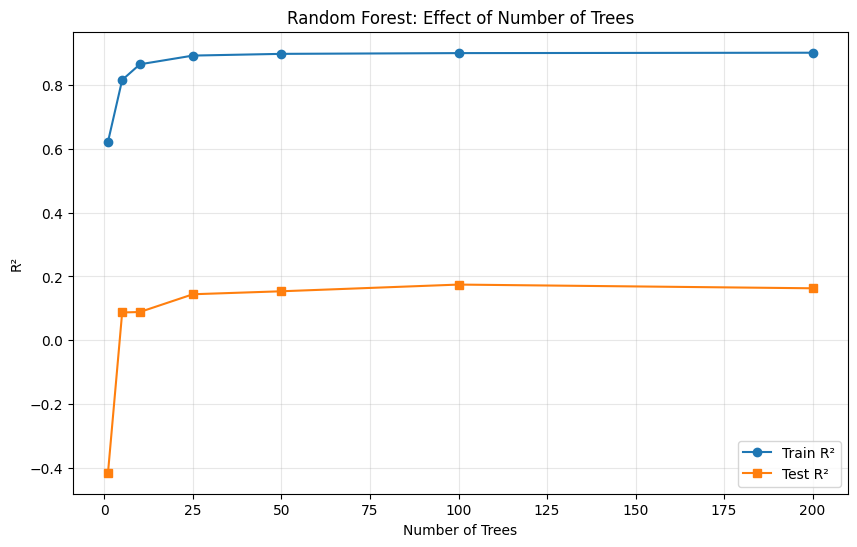

In [7]:
# Effect of number of trees
n_trees_range = [1, 5, 10, 25, 50, 100, 200]
scores = []

for n in n_trees_range:
    rf = RandomForestRegressor(n_estimators=n, max_depth=10, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    scores.append({
        'n_trees': n,
        'train': rf.score(X_train, y_train),
        'test': rf.score(X_test, y_test)
    })

scores_df = pd.DataFrame(scores)

plt.figure(figsize=(10, 6))
plt.plot(scores_df['n_trees'], scores_df['train'], 'o-', label='Train R²')
plt.plot(scores_df['n_trees'], scores_df['test'], 's-', label='Test R²')
plt.xlabel('Number of Trees')
plt.ylabel('R²')
plt.title('Random Forest: Effect of Number of Trees')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

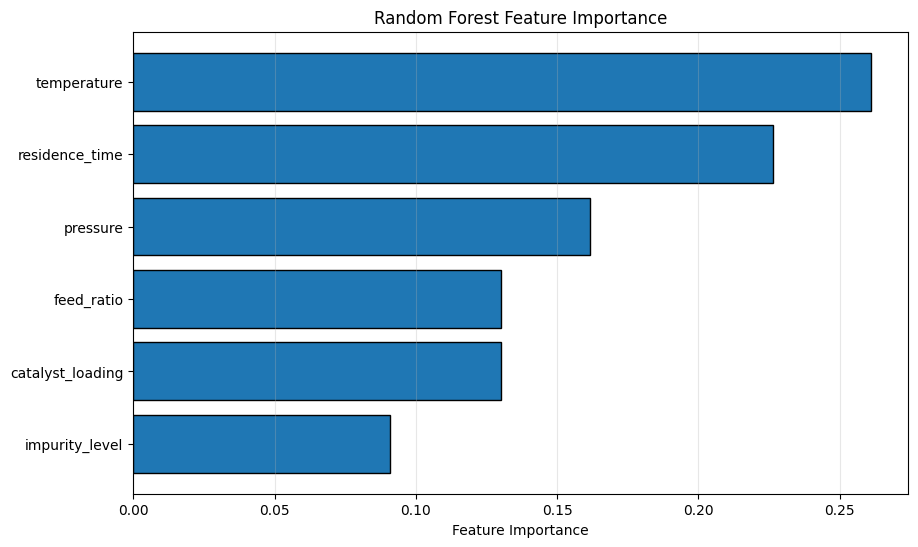

In [8]:
# Feature importance from Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'], importance['Importance'], edgecolor='black')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.grid(True, alpha=0.3, axis='x')
plt.show()

```{index} Gradient Boosting, learning_rate
```


## Gradient Boosting: Sequential Error Correction

Boosting takes a different approach than bagging. Instead of averaging independent models, it builds models **sequentially**, with each one correcting the errors of the previous.

### The Key Idea

1. Fit a model to the data
2. Look at what it got wrong (the residuals)
3. Fit a new model specifically to predict those errors
4. Add the new model to the ensemble
5. Repeat

Each new model focuses on the "hard cases" that previous models missed.

### Why It Works

- **Reduces bias**: Each iteration reduces the overall error
- **Builds complexity gradually**: Starts simple, adds detail where needed
- **Focuses effort**: Spends modeling capacity on difficult regions

### The Tradeoff: Overfitting Risk

Unlike Random Forests (which rarely overfit), boosting can overfit if you:
- Use too many iterations
- Use a learning rate that's too high
- Don't use regularization

The **learning_rate** parameter controls how much each tree contributes. Lower values are more conservative but need more trees.

In [9]:
# Gradient Boosting
gb = GradientBoostingRegressor(
    n_estimators=100, 
    max_depth=5, 
    learning_rate=0.1,
    random_state=42
)
gb.fit(X_train, y_train)

print("Gradient Boosting:")
print(f"  Training R²: {gb.score(X_train, y_train):.4f}")
print(f"  Test R²: {gb.score(X_test, y_test):.4f}")

Gradient Boosting:
  Training R²: 0.9776
  Test R²: 0.1224


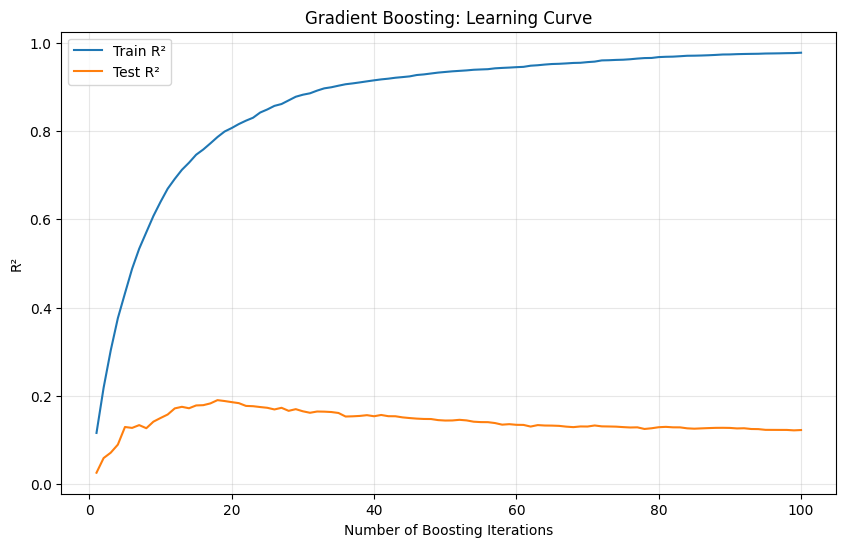

In [10]:
# Learning curve: how error decreases with more trees
train_scores = []
test_scores = []

# Get staged predictions
for i, y_pred in enumerate(gb.staged_predict(X_train)):
    train_scores.append(r2_score(y_train, y_pred))

for i, y_pred in enumerate(gb.staged_predict(X_test)):
    test_scores.append(r2_score(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_scores)+1), train_scores, label='Train R²')
plt.plot(range(1, len(test_scores)+1), test_scores, label='Test R²')
plt.xlabel('Number of Boosting Iterations')
plt.ylabel('R²')
plt.title('Gradient Boosting: Learning Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

```{index} XGBoost
```


## XGBoost: Gradient Boosting on Steroids

XGBoost (eXtreme Gradient Boosting) is a highly optimized implementation that dominates machine learning competitions. It adds several improvements:

### Key Innovations

1. **Regularization**: Built-in L1/L2 penalties prevent overfitting
2. **Parallel processing**: Splits training across CPU cores
3. **Missing values**: Learns the best direction for missing data
4. **Pruning**: Grows tree then prunes, rather than stopping early
5. **Cache optimization**: Faster memory access patterns

### When to Use XGBoost

- You want maximum predictive performance
- You have structured/tabular data (not images or text)
- You have time to tune hyperparameters
- Interpretability is secondary to accuracy

### XGBoost vs Random Forest

| Aspect | Random Forest | XGBoost |
|--------|---------------|---------|
| Training | Embarrassingly parallel | Sequential (within boosting) |
| Overfitting | Rarely | Need to tune carefully |
| Default performance | Good out of box | Often needs tuning |
| Speed | Faster training | Can be slower |
| Best performance | Very good | Often better (tuned) |

In [11]:
# XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
xgb_model.fit(X_train, y_train)

print("XGBoost:")
print(f"  Training R²: {xgb_model.score(X_train, y_train):.4f}")
print(f"  Test R²: {xgb_model.score(X_test, y_test):.4f}")

XGBoost:
  Training R²: 0.9706
  Test R²: 0.1201


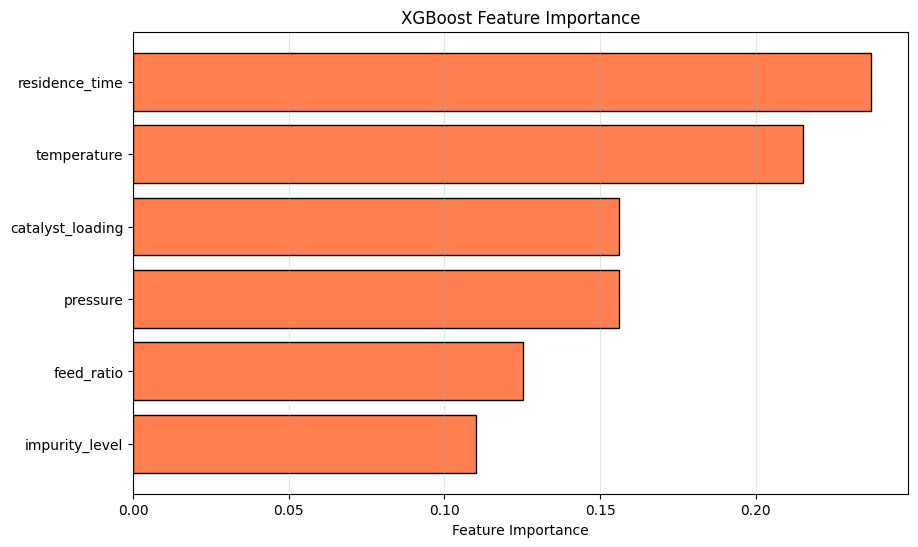

In [12]:
# XGBoost feature importance
importance_xgb = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importance_xgb['Feature'], importance_xgb['Importance'], 
         edgecolor='black', color='coral')
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.grid(True, alpha=0.3, axis='x')
plt.show()

## Hyperparameter Tuning

In [13]:
# Grid search for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Random Forest Best Parameters:")
print(f"  {grid_rf.best_params_}")
print(f"  Best CV R²: {grid_rf.best_score_:.4f}")
print(f"  Test R²: {grid_rf.score(X_test, y_test):.4f}")

Random Forest Best Parameters:
  {'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 200}
  Best CV R²: 0.3879
  Test R²: 0.1679


In [14]:
# Grid search for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

xgb_model = xgb.XGBRegressor(random_state=42)
grid_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='r2', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print("\nXGBoost Best Parameters:")
print(f"  {grid_xgb.best_params_}")
print(f"  Best CV R²: {grid_xgb.best_score_:.4f}")
print(f"  Test R²: {grid_xgb.score(X_test, y_test):.4f}")


XGBoost Best Parameters:
  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
  Best CV R²: 0.3649
  Test R²: 0.1842


## Model Comparison

In [15]:
# Compare all methods
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    
    results.append({
        'Model': name,
        'Train R²': train_score,
        'Test R²': test_score,
        'CV R² (mean)': cv_scores.mean(),
        'CV R² (std)': cv_scores.std()
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

            Model  Train R²   Test R²  CV R² (mean)  CV R² (std)
Linear Regression  0.384361  0.086325      0.292036     0.087791
    Decision Tree  0.963822 -0.731188     -0.208334     0.158234
    Random Forest  0.899099  0.174583      0.345695     0.059007
Gradient Boosting  0.977639  0.122411      0.330976     0.067990
          XGBoost  0.997910  0.048670      0.275404     0.108284


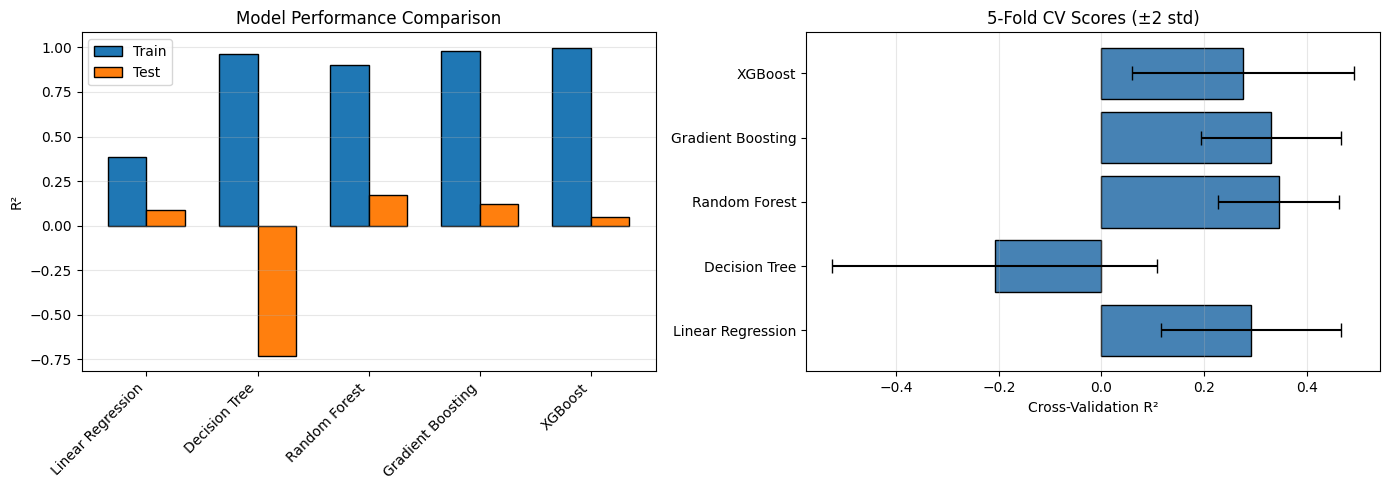

In [16]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of scores
x = np.arange(len(results_df))
width = 0.35

axes[0].bar(x - width/2, results_df['Train R²'], width, label='Train', edgecolor='black')
axes[0].bar(x + width/2, results_df['Test R²'], width, label='Test', edgecolor='black')
axes[0].set_xticks(x)
axes[0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0].set_ylabel('R²')
axes[0].set_title('Model Performance Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# CV scores with error bars
axes[1].barh(results_df['Model'], results_df['CV R² (mean)'], 
             xerr=results_df['CV R² (std)'] * 2, capsize=5, edgecolor='black', color='steelblue')
axes[1].set_xlabel('Cross-Validation R²')
axes[1].set_title('5-Fold CV Scores (±2 std)')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

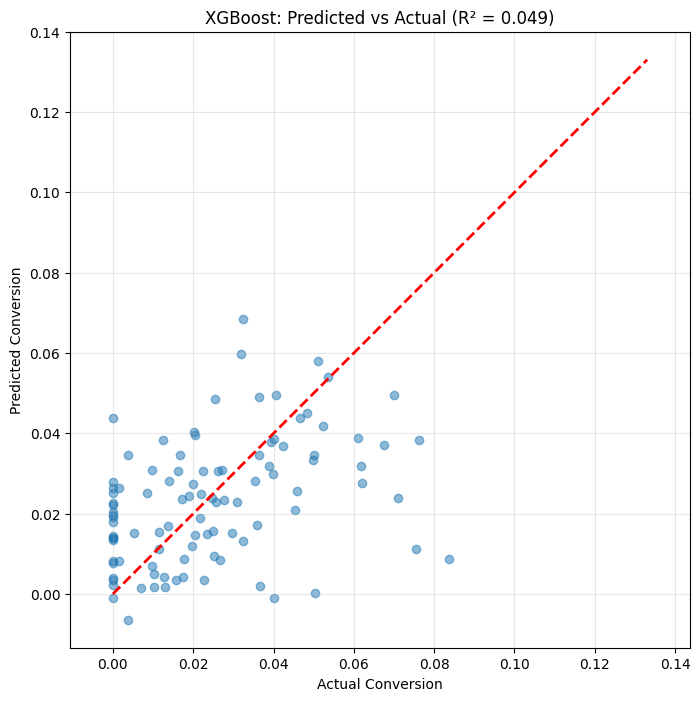

In [17]:
# Predicted vs Actual for best model
best_model = xgb.XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
plt.xlabel('Actual Conversion')
plt.ylabel('Predicted Conversion')
plt.title(f'XGBoost: Predicted vs Actual (R² = {r2_score(y_test, y_pred):.3f})')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

```{index} feature importance
```


## Key Hyperparameters

### Random Forest
| Parameter | Effect |
|-----------|--------|
| n_estimators | More trees = better, but slower |
| max_depth | Deeper = more complex, can overfit |
| min_samples_split | Higher = more regularization |
| max_features | Random feature subset size |

### Gradient Boosting / XGBoost
| Parameter | Effect |
|-----------|--------|
| n_estimators | More iterations, can overfit |
| learning_rate | Smaller = more robust, needs more trees |
| max_depth | Shallower trees often work well (3-10) |
| subsample | Fraction of samples per tree |

In [18]:
%pip install -q jupyterquiz
from jupyterquiz import display_quiz

display_quiz("https://raw.githubusercontent.com/jkitchin/s26-06642/main/dsmles/10-ensemble-methods/quizzes/ensemble-methods-quiz.json")

/bin/bash: pip: command not found


<IPython.core.display.Javascript object>

## Recommended Reading

These resources cover ensemble learning theory and practical implementation:

1. **[Scikit-learn Ensemble Methods](https://scikit-learn.org/stable/modules/ensemble.html)** - Official documentation on Random Forests, Gradient Boosting, and other ensemble methods. Includes guidance on hyperparameter selection.

2. **[XGBoost Documentation](https://xgboost.readthedocs.io/en/stable/)** - Comprehensive guide to XGBoost including parameter tuning, handling missing values, and feature importance. Essential for production-grade boosting.

3. **[An Introduction to Statistical Learning, Chapter 8](https://www.statlearning.com/)** - Covers tree-based methods including bagging, random forests, and boosting with clear explanations and examples.

4. **[Random Forests (Breiman, Machine Learning 2001)](https://link.springer.com/article/10.1023/A:1010933404324)** - The original Random Forest paper. Readable and provides intuition for why combining trees works so well.

5. **[A Gentle Introduction to Gradient Boosting](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)** - Step-by-step explanation of how gradient boosting builds models sequentially. Good for building intuition before diving into code.

## Summary: Ensemble Methods Decision Guide

### When to Use What

```
Need a quick, reliable baseline?
└── Random Forest (works well out of the box)

Need maximum performance and have time to tune?
└── XGBoost or LightGBM

Have very large data (millions of rows)?
└── LightGBM (fastest) or XGBoost with subsampling

Need interpretability?
└── Single tree (if accuracy allows) or use SHAP with ensembles
```

### Key Hyperparameters to Tune

| Method | Most Important | Secondary |
|--------|---------------|-----------|
| Random Forest | n_estimators, max_depth | min_samples_split, max_features |
| Gradient Boosting | n_estimators, learning_rate | max_depth, subsample |
| XGBoost | learning_rate, n_estimators | max_depth, reg_alpha, reg_lambda |

### Practical Tips

1. **Start with Random Forest**: It's hard to mess up. Good baseline.
2. **Don't tune n_estimators alone**: More trees are always better (just slower). Focus on other parameters.
3. **For boosting, tune learning_rate and n_estimators together**: Lower rate → more trees needed.
4. **Use early stopping**: Prevents overfitting in boosting automatically.
5. **Feature importance is useful but imperfect**: Use SHAP for more reliable interpretation.

### Common Pitfalls

- Not enough trees (RF): 100+ is usually good, 500+ is safer
- Learning rate too high (boosting): Start with 0.01-0.1
- Not tuning XGBoost: Defaults are often suboptimal
- Ignoring feature importance: Ensembles can reveal which features matter

## Next Steps

In the next module, we'll explore clustering for unsupervised learning—finding structure in data without labels.

---

## The Catalyst Crisis: Chapter 10 - "A Thousand Trees"

*A story about ensemble methods and the breakthrough moment*

---

The Random Forest finished training in thirty seconds. The results appeared on screen:

**Test R²: 0.92**

Alex stared. Then checked the numbers again.

"That's... substantially better," Maya said, understating it considerably.

They'd been stuck at 0.80 for weeks. Now, with 500 decision trees voting together, the model had leaped forward.

"Run the feature importance," Jordan said.

The bar chart appeared. And there it was, undeniable now: *catalyst_lot* at the top. *catalyst_age* second. *temperature* third. Everything else—pressure, flow rates, nutrient levels—was distant noise.

"It's the catalyst," Alex said. "The model is telling us it's the catalyst."

Sam ran XGBoost for comparison—gradient boosting instead of bagging. Test R² of 0.94. Same feature importance ranking. Two completely different ensemble methods, pointing at the same answer.

Frank Morrison joined the call, and for the first time, he looked genuinely curious rather than skeptical.

"So you're saying the catalyst is the problem?"

"Not all catalyst. Specific lots." Alex pulled up the analysis. "Batches that used catalyst manufactured between March and August of last year have dramatically worse yields. Before March and after August—normal performance."

Frank was quiet for a long moment. "We switched suppliers in February. New contract."

The room went still.

"The new supplier. Something about their manufacturing process is different."

"We didn't know. They certified the same specs." Frank's voice was troubled. "How could we have known?"

"You couldn't. Not without this analysis." Alex felt the pieces clicking together—eighteen months of mystery, slowly resolving into a supply chain problem that no one had thought to look for. "The models don't just predict. They explain. And they're explaining that something changed in your catalyst supply."

After the call, Maya found Alex at the mystery board, adding the latest clue.

"We solved it," Maya said. "Right?"

"We found the correlation. We don't have the mechanism yet. Why is the new catalyst worse? What changed in their process?" Alex stepped back to look at the full board, now covered with sticky notes. "But we're close. Closer than anyone's been in eighteen months."

She noticed a new badge on her Academy profile: *Ensemble Master*.

Progress. Real progress.

---

*Continue to the next lecture to explore clustering and unsupervised learning...*